<a href="https://colab.research.google.com/github/hwansnaa/InfoGAN/blob/main/infoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

MNIST

In [52]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

        self.conv4 = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        output = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)
        probs = torch.sigmoid(self.conv4(output))

        return probs, output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

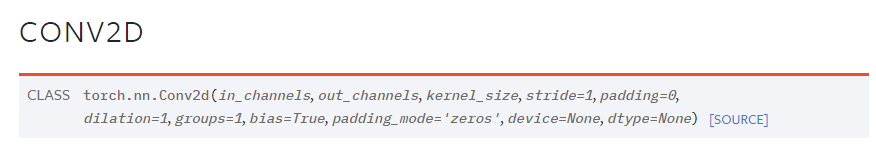

In [4]:
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 100,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,
    'dataset' : 'MNIST'
}
params['num_z'] = 62
params['num_dis_c'] = 1
params['dis_c_dim'] = 10
params['num_con_c'] = 2

In [14]:
def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    input -> 
    n_dis_c : Discrete latent value의 수(mnist의 경우 1 (Domain))
    dis_c_dim : Disctrete latent value의 Dimension(mnist의 경우 10 (0-9의 class 수))
    n_con_c : Continuous latent value의 수(mnist의 경우 2(bold, rotate))
    n_z : random noise z의 dimension
    batch_size : Batch Size
    device : GPU/CPU

    output -> 
    noise : 생성된 noise
    idx : 생성된 이미지의 Class value

    """
    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

In [53]:
class InfoGAN:
  def __init__(self, params):
      self.params = params
      self.netG = Generator()
      self.netD = Discriminator()
      self.netQ = QHead()
      self.optimD = optim.Adam([{'params': self.netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
      self.optimG = optim.Adam([{'params': self.netG.parameters()}, {'params': self.netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

      self.criterionD = nn.BCELoss() # Binary CrossEntropy / True, False
      self.criterionQ_dis = nn.CrossEntropyLoss() # Multiple Class
      self.criterionQ_con = nn.GaussianNLLLoss()
      
      self.device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

  def train(self, ds, epochs = 100):
    self.netG = self.netG.to(self.device)
    self.netD = self.netD.to(self.device)
    self.netQ = self.netQ.to(self.device)
    self.G_losses = []
    self.D_losses = []
    self.val_outputs = []
    self.val_noise, idx = noise_sample(self.params['num_dis_c'], self.params['dis_c_dim'], self.params['num_con_c'], self.params['num_z'], 36, self.device)
    for epoch in range(epochs):
      for i, (data, _) in enumerate(ds, 0):
          # Get batch size
          b_size = data.size(0)
          # Transfer data tensor to GPU/CPU (device)
          real_data = data.to(self.device)

          self.optimD.zero_grad()

          # Real data
          label = torch.full((b_size, ), 1, device=self.device, dtype=torch.float32)
          probs_real, _ = self.netD(real_data)
          loss_real = self.criterionD(probs_real.view(-1), label)
          
          loss_real.backward()

          # Fake data
          label.fill_(0)
          noise, idx = noise_sample(self.params['num_dis_c'], self.params['dis_c_dim'], self.params['num_con_c'], self.params['num_z'], b_size, self.device)
          fake_data = self.netG(noise)
          probs_fake, output_fake = self.netD(fake_data.detach())
          loss_fake = self.criterionD(probs_fake.view(-1), label)
          
          loss_fake.backward()

          # Net Loss for the discriminator & Update
          D_loss = loss_real + loss_fake
          
          self.optimD.step()

          # Updating Generator and QHead
          self.optimG.zero_grad()

          # Fake data treated as real.
          probs_fake, output_fake = self.netD(fake_data)
          label.fill_(1)
          gen_loss = self.criterionD(probs_fake.view(-1), label)

          q_logits, q_mu, q_var = self.netQ(output_fake)
          target = torch.LongTensor(idx).to(self.device)
          # Calculating loss for discrete latent code.
          dis_loss = 0
          for j in range(self.params['num_dis_c']):
              dis_loss += self.criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

          # Calculating loss for continuous latent code.
          con_loss = 0
          if (self.params['num_con_c'] != 0):
              con_loss = self.criterionQ_con(noise[:,-self.params['num_con_c'] : ].view(-1, self.params['num_con_c']), q_mu, q_var)*0.1

          # Net loss for generator.
          G_loss = gen_loss + dis_loss + con_loss
          # Calculate gradients.
          G_loss.backward()
          # Update parameters.
          self.optimG.step()

          # Check progress of training.
          if i != 0 and i%100 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch+1,self. params['num_epochs'], i, len(ds), 
                      D_loss.item(), G_loss.item()))

          # Save the losses for plotting.
          self.G_losses.append(G_loss.item())
          self.D_losses.append(D_loss.item())
      with torch.no_grad():
        self.netG.eval()
        val_output = self.netG(self.val_noise)
        grid_image = np.array(vutils.make_grid(val_output.detach().cpu(), normalize=True).permute(1, 2, 0))
        # self.save_image(self.normalize(grid_image), epoch)
        self.val_outputs.append(grid_image)

  @staticmethod
  def normalize(x):
    x = x * 255.0
    x = x.astype(np.uint8)
    return x

  @staticmethod
  def save_image(x, file_name):
      cv2.imwrite(f'val_data/{file_name}.png', x)

## 순서
1. Discriminator Update
2. Generator, QHead Update

In [54]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor()])
datasets = dsets.MNIST('data/mnist/', train='train', download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(datasets, 
                                            batch_size=64, 
                                            shuffle=True)

In [55]:
infoGAN = InfoGAN(params)
infoGAN.train(dataloader, 100)

[1/100][100/938]	Loss_D: 0.9479	Loss_G: 1.6114


KeyboardInterrupt: ignored

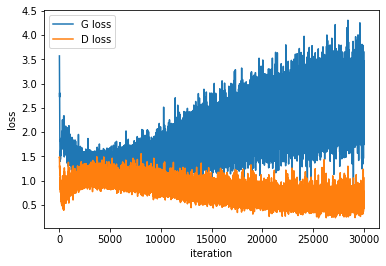

In [42]:
plt.plot(infoGAN.G_losses)
plt.plot(infoGAN.D_losses)
plt.legend(['G loss', 'D loss'])
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

In [10]:
os.mkdir('val_data')

In [56]:
"""
Discriminator
input : torch.Size([64, 1, 28, 28])
x1 : torch.Size([64, 64, 14, 14])
x2 : torch.Size([64, 128, 7, 7])
output : torch.Size([64, 1024, 1, 1])
probs : torch.Size([64, 1, 1, 1])

QHead
input : torch.Size([64, 1024, 1, 1])
x : torch.Size([64, 128, 1, 1])
disc_logits : torch.Size([64, 10])
mu : torch.Size([64, 2])
var : torch.Size([64, 2])
"""

'\nDiscriminator\ninput : torch.Size([64, 1, 28, 28])\nx1 : torch.Size([64, 64, 14, 14])\nx2 : torch.Size([64, 128, 7, 7])\noutput : torch.Size([64, 1024, 1, 1])\nprobs : torch.Size([64, 1, 1, 1])\n\nQHead\ninput : torch.Size([64, 1024, 1, 1])\nx : torch.Size([64, 128, 1, 1])\ndisc_logits : torch.Size([64, 10])\nmu : torch.Size([64, 2])\nvar : torch.Size([64, 2])\n'

In [57]:
# NLL Loss -> mu의 값과 같고, var은 크게